<a href="https://colab.research.google.com/github/s11000/pandas-data-frame/blob/main/%20asml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K


class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        shape = (height, width, depth)
        channelDim = -1

        if K.image_data_format() == "channels_first":
            shape = (depth, height, width)
            channelDim = 1

In [31]:
train = pd.read_csv("/content/ASML.csv")
df=train
 
  

In [32]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,174.139999,177.839996,173.979996,177.729996,168.725327,818600
1,2018-01-03,177.729996,179.580002,177.679993,179.080002,170.006943,1054200
2,2018-01-04,180.490005,181.770004,179.399994,180.750000,171.592300,915600
3,2018-01-05,180.839996,183.449997,180.750000,182.869995,173.604919,516100
4,2018-01-08,183.190002,184.460007,182.809998,183.830002,174.516296,763900
...,...,...,...,...,...,...,...
1254,2022-12-23,546.869995,552.070007,542.530029,551.369995,551.369995,602600
1255,2022-12-27,546.049988,546.500000,536.510010,537.179993,537.179993,802600
1256,2022-12-28,536.700012,541.799988,529.010010,531.640015,531.640015,609900
1257,2022-12-29,541.200012,555.369995,540.150024,551.469971,551.469971,841000


In [34]:

def augFeatures(train):
  train["Date"] = pd.to_datetime(train["Date"])
  train["year"] = train["Date"].dt.year
  train["month"] = train["Date"].dt.month
  train["date"] = train["Date"].dt.day
  train["day"] = train["Date"].dt.dayofweek
  return train

In [35]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,174.139999,177.839996,173.979996,177.729996,168.725327,818600
1,2018-01-03,177.729996,179.580002,177.679993,179.080002,170.006943,1054200
2,2018-01-04,180.490005,181.770004,179.399994,180.750000,171.592300,915600
3,2018-01-05,180.839996,183.449997,180.750000,182.869995,173.604919,516100
4,2018-01-08,183.190002,184.460007,182.809998,183.830002,174.516296,763900
...,...,...,...,...,...,...,...
1254,2022-12-23,546.869995,552.070007,542.530029,551.369995,551.369995,602600
1255,2022-12-27,546.049988,546.500000,536.510010,537.179993,537.179993,802600
1256,2022-12-28,536.700012,541.799988,529.010010,531.640015,531.640015,609900
1257,2022-12-29,541.200012,555.369995,540.150024,551.469971,551.469971,841000


In [36]:
def normalize(train):
  train = train.drop(["Date"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm

In [37]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,174.139999,177.839996,173.979996,177.729996,168.725327,818600
1,2018-01-03,177.729996,179.580002,177.679993,179.080002,170.006943,1054200
2,2018-01-04,180.490005,181.770004,179.399994,180.750000,171.592300,915600
3,2018-01-05,180.839996,183.449997,180.750000,182.869995,173.604919,516100
4,2018-01-08,183.190002,184.460007,182.809998,183.830002,174.516296,763900
...,...,...,...,...,...,...,...
1254,2022-12-23,546.869995,552.070007,542.530029,551.369995,551.369995,602600
1255,2022-12-27,546.049988,546.500000,536.510010,537.179993,537.179993,802600
1256,2022-12-28,536.700012,541.799988,529.010010,531.640015,531.640015,609900
1257,2022-12-29,541.200012,555.369995,540.150024,551.469971,551.469971,841000


In [38]:

def buildTrain(train, pastDay=30, futureDay=5):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"]))
  return np.array(X_train), np.array(Y_train)

In [39]:

def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [54]:

def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [61]:
# read SPY.csv
train = pd.read_csv("/content/ASML.csv")

# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)

# Normalization
train_norm = normalize(train_Aug)

# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(train_norm, 30, 5)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)

In [62]:

def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [63]:
# read SPY.csv
train =  pd.read_csv("/content/ASML.csv")

# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)

# Normalization
train_norm = normalize(train_Aug)

# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(train_norm, 30, 5)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)

In [64]:

def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [65]:

train = pd.read_csv("/content/ASML.csv")
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 10)             840       
                                                                 
 time_distributed (TimeDistr  (None, 1, 1)             11        
 ibuted)                                                         
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 5s 198ms/step - loss: 0.0455 - val_loss: 0.0438
Epoch 2/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0376 - val_loss: 0.0362
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0304 - val_loss: 0.0290
Epoch 4/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0240 - val_loss

In [66]:
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [67]:

train = pd.read_csv("/content/ASML.csv")
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 30, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 3s 125ms/step - loss: 0.0422 - val_loss: 0.0267
Epoch 2/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0208 - val_loss: 0.0111
Epoch 3/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 4/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 5/1000
9/9 [==============================] - 0s 

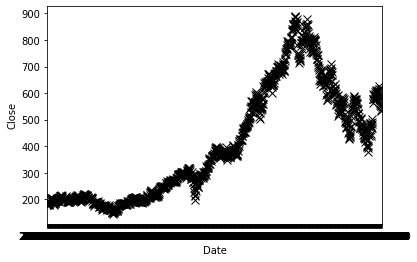

In [98]:
  
sns.boxplot(x=df["Date"],y=df["Close"],showmeans=True,
 meanprops={
     "marker":"x",
     "markeredgecolor":"black",
     "markersize":"8"
 })
plt.show()

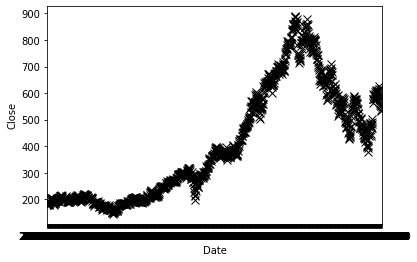

In [99]:
 
sns.boxplot(x=df["Date"],y=df["Close"],showmeans=True,
 meanprops={
     "marker":"x",
     "markeredgecolor":"black",
     "markersize":"8"
 })
plt.show()

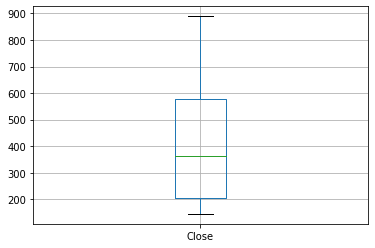

In [100]:
df.boxplot(column=['Close'])

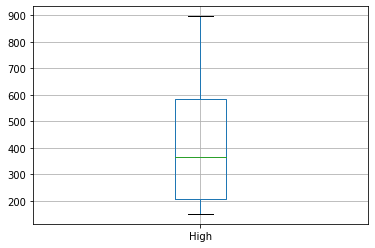

In [101]:
df.boxplot(column=['High'])

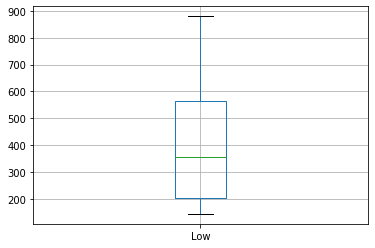

In [102]:
df.boxplot(column=['Low'])

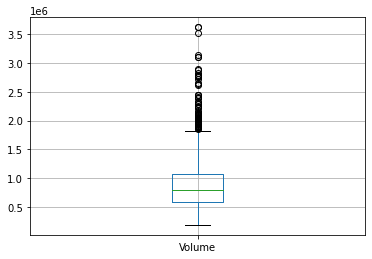

In [104]:
df.boxplot(column=['Volume'])

In [68]:
def buildOneToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (5, 1)
  model.add(Dense(1))
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [94]:

train = pd.read_csv("/content/2330.TW.csv")
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildOneToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 1)             0         
 or)                                                             
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 3s 68ms/step - loss: 0.0556 - val_loss: 0.0525
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0445
Epoch 3/1000
9/9 [==============================] - 0s 5m

In [70]:
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [71]:

train = pd.read_csv("/content/ASML.csv")
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 10)             840       
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             11        
 tributed)                                                       
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 3s 72ms/step - loss: 0.1831 - val_loss: 0.1596
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1515 - val_loss: 0.1321
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1251 - val_loss: 0.1088
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1029 - val_loss: 

In [72]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

# Import the training set
dataset_train = pd.read_csv("/content/ASML.csv") # 讀取訓練集
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

In [73]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [74]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 1258):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [75]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [76]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

In [77]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [78]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [79]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 13s 124ms/step - loss: 0.0225
Epoch 2/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0049
Epoch 3/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0050
Epoch 4/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0042
Epoch 6/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0045
Epoch 7/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0052
Epoch 8/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 5s 121ms/step - loss: 0.0035
Epoch 10/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0035
Epoch 11/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0032
Epoch 12/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0041
Epoch 13/100

In [82]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

# Import the training set
dataset_train = pd.read_csv("/content/ASML.csv") # 讀取訓練集
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

In [85]:
dataset_test = pd.read_csv("/content/ASML.csv") 
real_stock_price = dataset_test.iloc[:, 1:2].values

In [86]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 80):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [87]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale

1/1 [==============================] - 2s 2s/step


In [88]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 80):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [89]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale

1/1 [==============================] - 0s 48ms/step


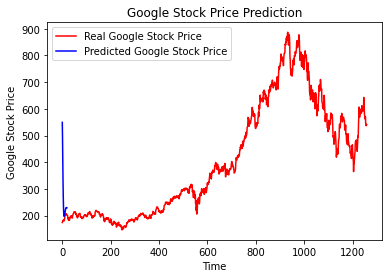

In [90]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')  # 藍線表示預測股價
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [91]:

# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

# Import the training set
dataset_train = pd.read_csv('/content/2330.TW.csv')  # 讀取訓練集
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

In [92]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)